In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    
seed_everything()

# The famous Air Passenger dataset

In [3]:
data = sm.datasets.get_rdataset("AirPassengers").data

X = data['value']
cutoff = int(len(X) * 0.2)
Y = X[-cutoff:]
X = X[:-cutoff]

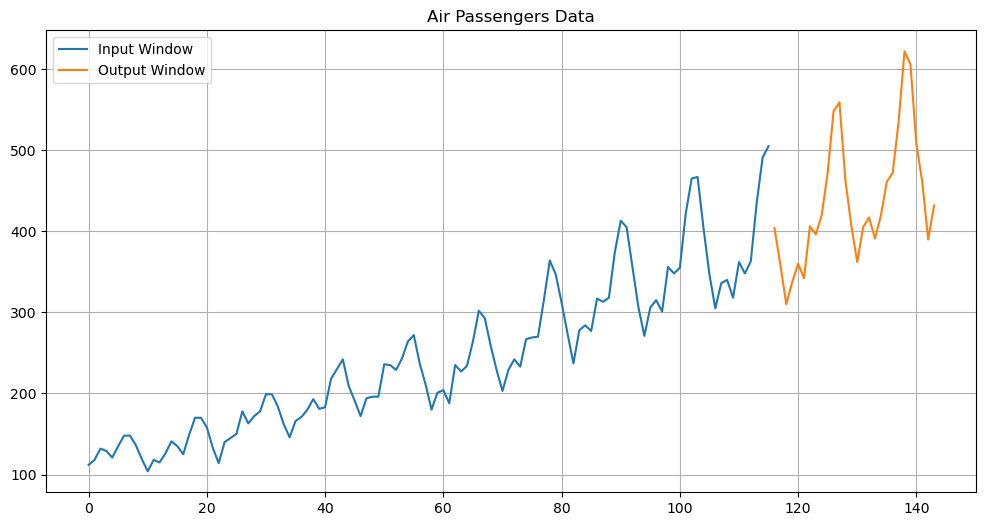

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Output Window')
ax.set_title(f'Air Passengers Data')
ax.grid()
ax.legend()
plt.show()

### Checking that the data series is NOT stationary with ADF test and ACF/PACF

In [5]:
result = adfuller(X, maxlag=None, regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result

print('ADF Statistic:', adf_stat)
print('p-value:', pvalue)
print('Used lag:', usedlag)
print('Number of obs:', nobs)
print('Critical Values:', crit_vals)
if icbest is not None:
    print('IC best:', icbest)

# optionally format output
out = pd.Series({
    'adf_stat': adf_stat,
    'pvalue': pvalue,
    'usedlag': usedlag,
    'nobs': nobs,
    'icbest': icbest
})
for k, v in crit_vals.items():
    out[f'cv_{k}'] = v
print(out)

ADF Statistic: -0.07663036122509477
p-value: 0.9517170622658595
Used lag: 13
Number of obs: 102
Critical Values: {'1%': np.float64(-3.4961490537199116), '5%': np.float64(-2.8903209639580556), '10%': np.float64(-2.5821223452518263)}
IC best: 750.6502560851972
adf_stat     -0.076630
pvalue        0.951717
usedlag      13.000000
nobs        102.000000
icbest      750.650256
cv_1%        -3.496149
cv_5%        -2.890321
cv_10%       -2.582122
dtype: float64


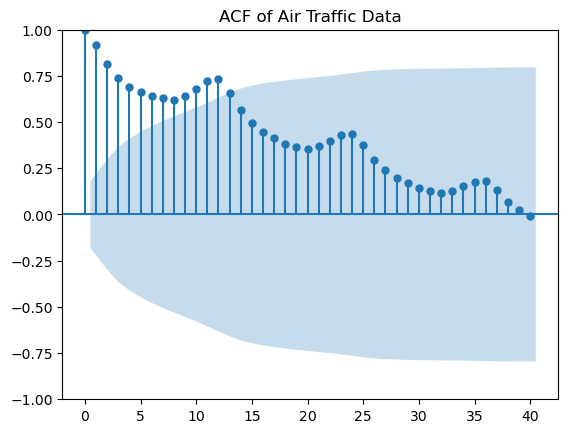

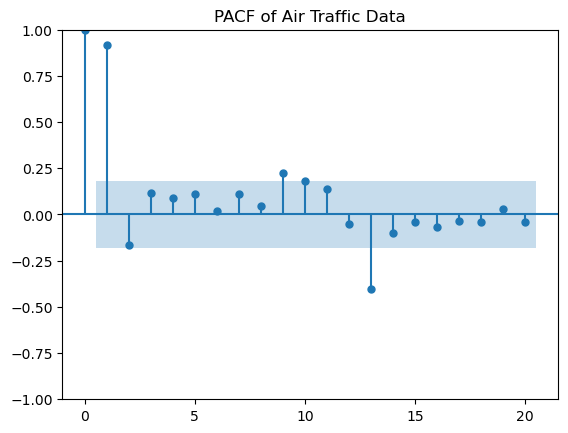

In [6]:
acf_original = plot_acf(X, lags=40, alpha=0.05, title='ACF of Air Traffic Data')
pacf_original = plot_pacf(X, lags=20, alpha=0.05, title='PACF of Air Traffic Data')

NB : PACF plot suggests p = 13

### Differenciating until stationarity : need twice. Then checking stationarity

In [7]:
# Once : not enough
df_X = pd.DataFrame(X)
diff = df_X.diff().dropna()

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = adfuller(diff, maxlag=None, regression='c', autolag='AIC')
print(f'ADF Statistic after differencing once : {adf_stat:.3e}, p-value: {pvalue:.6f}')

ADF Statistic after differencing once : -2.709e+00, p-value: 0.072530


In [8]:
# Twice : stationary
diff = df_X.diff().diff().dropna()

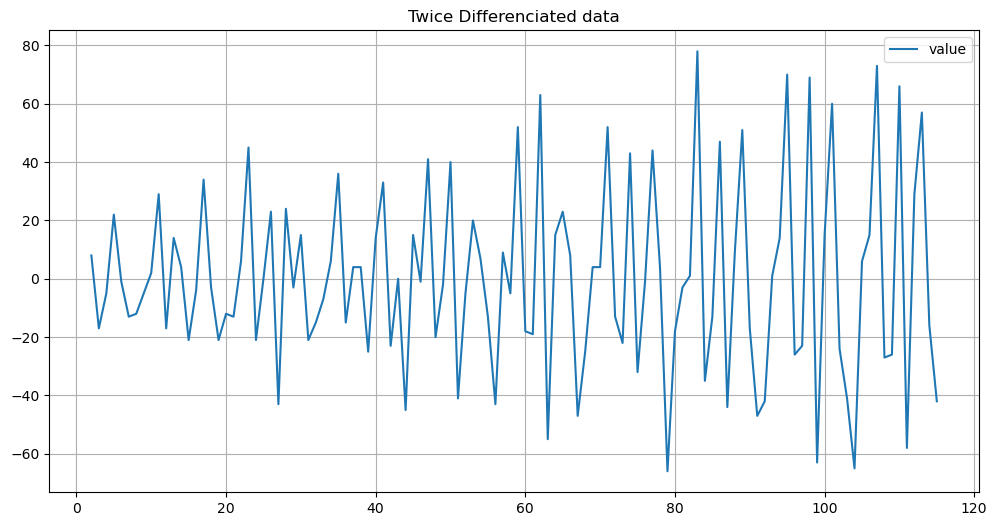

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
diff.plot(ax=ax, title='Twice Differenciated data')
ax.grid()
plt.show()

In [10]:
series = diff.values.astype(float)   # e.g., log returns
result = adfuller(series, maxlag=None, regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result

print('ADF Statistic:', adf_stat)
print('p-value:', pvalue)
print('Used lag:', usedlag)
print('Number of obs:', nobs)
print('Critical Values:', crit_vals)
if icbest is not None:
    print('IC best:', icbest)

# optionally format output
out = pd.Series({
    'adf_stat': adf_stat,
    'pvalue': pvalue,
    'usedlag': usedlag,
    'nobs': nobs,
    'icbest': icbest
})
for k, v in crit_vals.items():
    out[f'cv_{k}'] = v
print(out)

ADF Statistic: -6.924986232610697
p-value: 1.1212931422402122e-09
Used lag: 13
Number of obs: 100
Critical Values: {'1%': np.float64(-3.497501033), '5%': np.float64(-2.89090644), '10%': np.float64(-2.5824349)}
IC best: 738.7171667341
adf_stat   -6.924986e+00
pvalue      1.121293e-09
usedlag     1.300000e+01
nobs        1.000000e+02
icbest      7.387172e+02
cv_1%      -3.497501e+00
cv_5%      -2.890906e+00
cv_10%     -2.582435e+00
dtype: float64


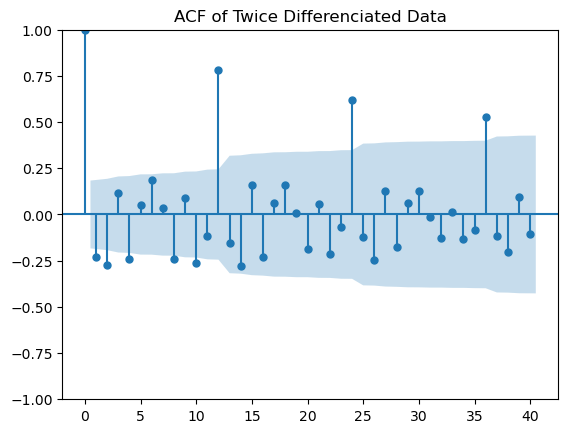

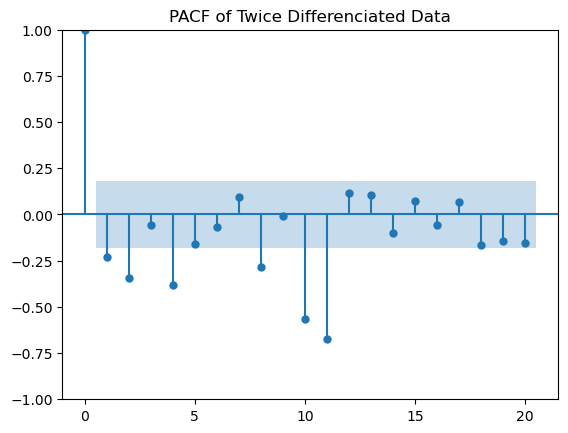

In [13]:
acf_original = plot_acf(diff, lags=40, title='ACF of Twice Differenciated Data')
pacf_original = plot_pacf(diff, lags=20, title='PACF of Twice Differenciated Data')

Even though the ADF test is saying the twice-differenctiated data is stationary, the ACF,PACF plots are telling a different story.

### Parameters : manual choice
- d=2 : given by differenciating twice
- p=13 : given by PACF plot on original data
- q=2

In [14]:
manual_model = ARIMA(X, order=(13,2,2))
manual_model_fit = manual_model.fit(method_kwargs={"maxiter":5000, "pgtol":1e-6})
print(manual_model_fit.summary())

/home/benjamin/anaconda3/envs/trading/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/benjamin/anaconda3/envs/trading/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  116
Model:                ARIMA(13, 2, 2)   Log Likelihood                -419.363
Date:                Fri, 28 Nov 2025   AIC                            870.726
Time:                        14:14:51   BIC                            914.505
Sample:                             0   HQIC                           888.494
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0170      0.118     -8.598      0.000      -1.249      -0.785
ar.L2         -0.2786      0.150     -1.863      0.062      -0.572       0.014
ar.L3         -0.2371      0.161     -1.474      0.1

### Checking residuals...

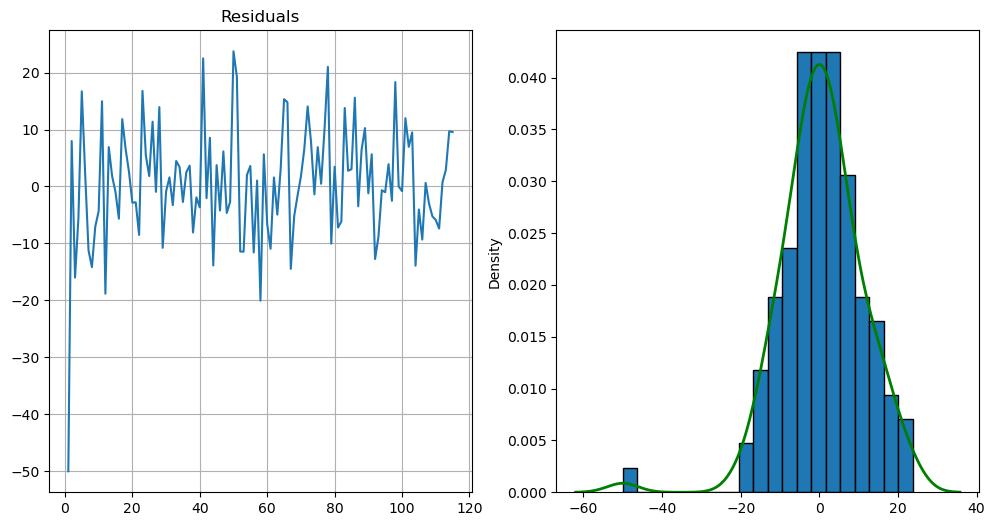

In [21]:
residuals = manual_model_fit.resid[1:]  # skip first NaN value
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].plot(residuals)
ax[0].set_title("Residuals")
ax[0].grid()
ax[1].hist(residuals, bins=20, edgecolor='black', density=True)
sns.kdeplot(residuals, ax=ax[1], color='green', lw=2, fill=False)  # use fill=True, alpha=0.3 to fill
plt.show()

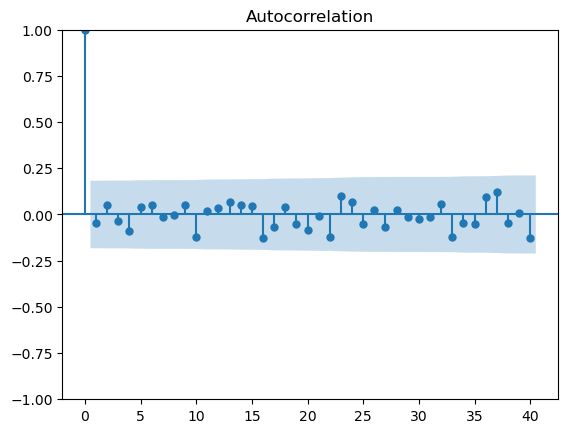

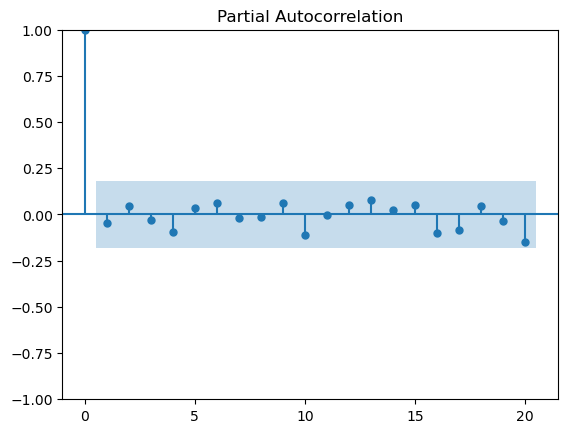

In [22]:
acf_resid = plot_acf(residuals, lags=40)
pacf_resid = plot_pacf(residuals, lags=20)

### Making predictions

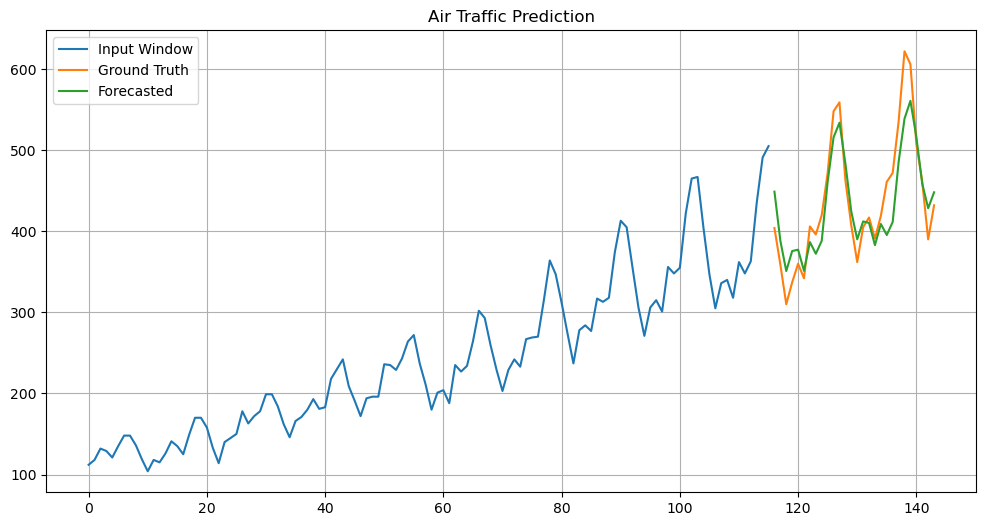

In [23]:
manual_forecast = manual_model_fit.forecast(steps=len(Y))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Ground Truth')
ax.plot(range(len(X), len(X) + len(manual_forecast)), manual_forecast, label='Forecasted')
ax.set_title(f'Air Traffic Prediction')
ax.grid()
ax.legend()
plt.show()

### Using AIC criterion to find optimal parameters

In [24]:
import pmdarima as pm
auto_model = pm.auto_arima(X, seasonal=True, stepwise=True)
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  116
Model:               SARIMAX(4, 1, 2)   Log Likelihood                -523.507
Date:                Fri, 28 Nov 2025   AIC                           1061.014
Time:                        14:17:57   BIC                           1080.229
Sample:                             0   HQIC                          1068.813
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2368      0.136      1.740      0.082      -0.030       0.504
ar.L2          0.3842      0.133      2.894      0.004       0.124       0.644
ar.L3         -0.2012      0.100     -2.021      0.0

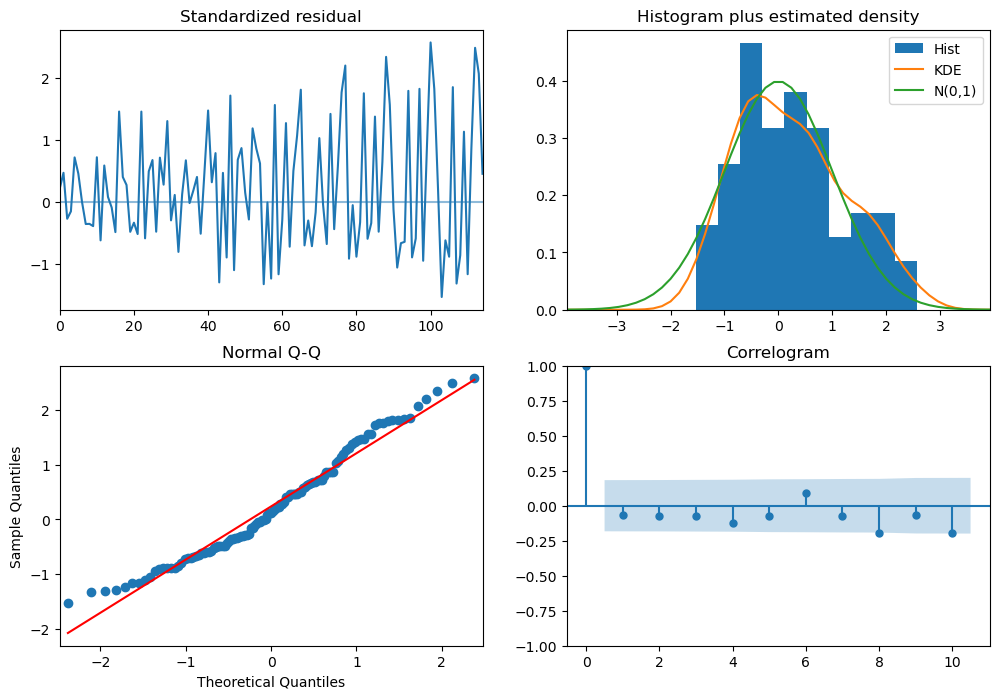

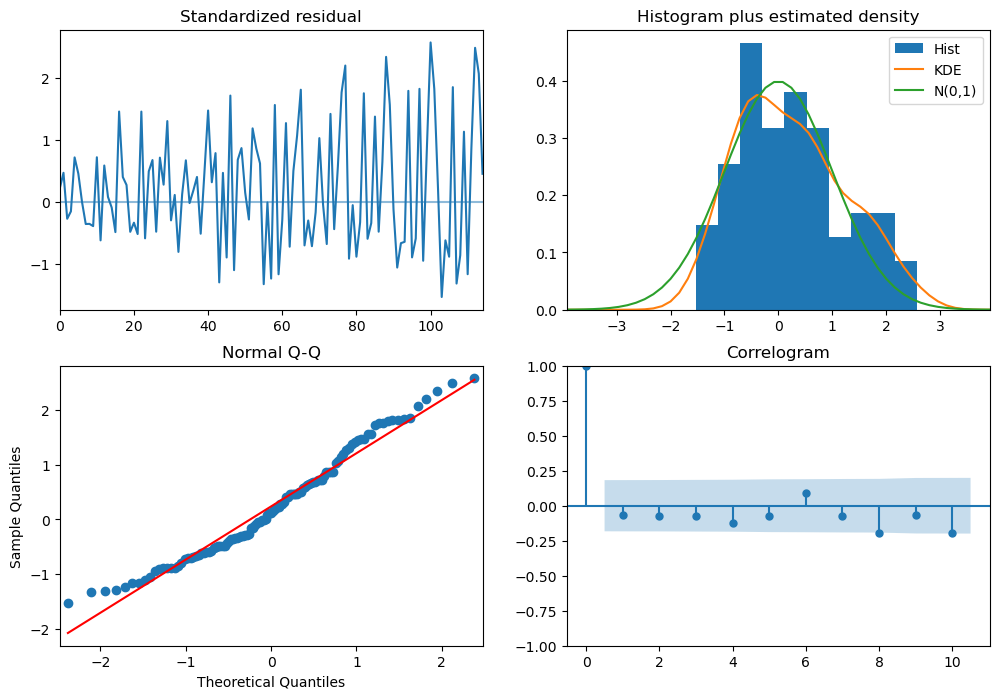

In [25]:
auto_model.plot_diagnostics(figsize=(12,8))

In [26]:
auto_model = ARIMA(X, order=(4,1,2))
auto_model_fit = auto_model.fit()
print(auto_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  116
Model:                 ARIMA(4, 1, 2)   Log Likelihood                -523.507
Date:                Fri, 28 Nov 2025   AIC                           1061.014
Time:                        14:18:01   BIC                           1080.229
Sample:                             0   HQIC                          1068.813
                                - 116                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2368      0.136      1.740      0.082      -0.030       0.504
ar.L2          0.3842      0.133      2.894      0.004       0.124       0.644
ar.L3         -0.2012      0.100     -2.021      0.0

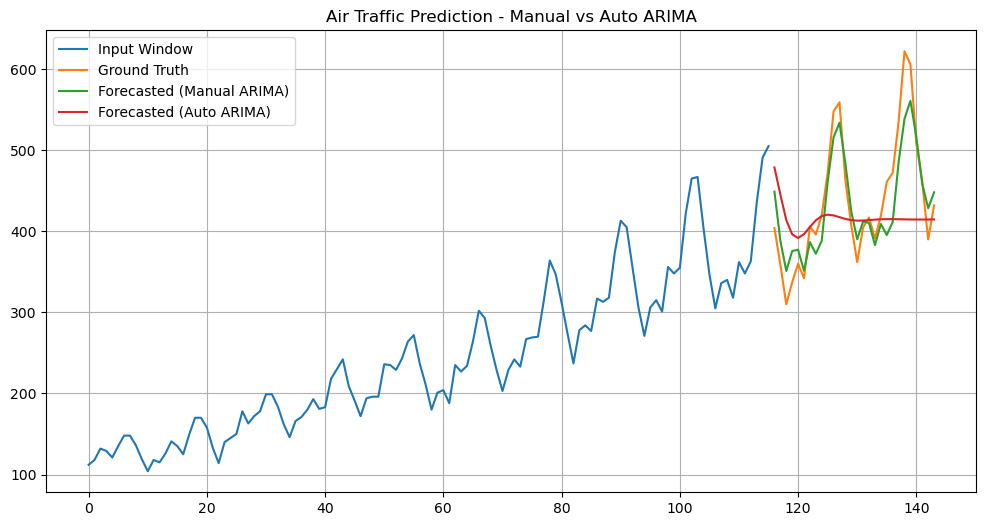

In [27]:
auto_forecast = auto_model_fit.forecast(steps=len(Y))

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(X, label='Input Window')
ax.plot(range(len(X), len(X) + len(Y)), Y, label='Ground Truth')
ax.plot(range(len(X), len(X) + len(manual_forecast)), manual_forecast, label='Forecasted (Manual ARIMA)')
ax.plot(range(len(X), len(X) + len(auto_forecast)), auto_forecast, label='Forecasted (Auto ARIMA)')
ax.set_title(f'Air Traffic Prediction - Manual vs Auto ARIMA')
ax.grid()
ax.legend()
plt.show()

### Metrics to compare models

In [28]:
mae = np.mean(np.abs(auto_forecast - Y))
print(f'Mean Absolute Error (Auto ARIMA): {mae:.3e}')
mae_manual = np.mean(np.abs(manual_forecast - Y))
print(f'Mean Absolute Error (Manual ARIMA): {mae_manual:.3e}')

mse = np.mean((auto_forecast - Y)**2)
print(f'Mean Squared Error (Auto ARIMA): {mse:.3e}')
mse_manual = np.mean((manual_forecast - Y)**2)
print(f'Mean Squared Error (Manual ARIMA): {mse_manual:.3e}')

Mean Absolute Error (Auto ARIMA): 6.071e+01
Mean Absolute Error (Manual ARIMA): 2.824e+01
Mean Squared Error (Auto ARIMA): 6.701e+03
Mean Squared Error (Manual ARIMA): 1.184e+03
